In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import pickle
import os
import sys

CURR_DIR = os.path.dirname(os.path.realpath("__file__"))
ROOT_DIR = os.path.abspath(os.path.join(CURR_DIR))
LIB_DIR = os.path.join(ROOT_DIR, 'libs')
# EXP_DIR = os.path.join(CURR_DIR, "maze_hard_exp")
EXP_DIR = os.path.join(CURR_DIR, "maze_hard_exp")
sys.path.append(LIB_DIR)

In [2]:
def get_global_bests(hist_fit: list) -> list:
    """globalベストのリストを返す

    Args:
        hist_fit (list): 各世代の最良適応度のリスト

    Returns:
        list: globalベストのリスト
    """
    global_bests = [hist_fit[0]]
    for i in range(1, len(hist_fit)):
        if hist_fit[i] > global_bests[-1]:
            global_bests.append(hist_fit[i])
        else:
            global_bests.append(global_bests[-1])

    return global_bests

def get_mean_std(df_hist_pop: pd.DataFrame) -> tuple:
    """各世代の平均適応度、標準偏差を返す

    Args:
        df_hist_pop (pd.DataFrame): 各世代の適応度のDataFrame

    Returns:
        tuple: 各世代の平均適応度、標準偏差のリスト
    """
    try:
        hist_avg_fit = df_hist_pop.groupby("generation").mean()["fitness"].values
        hist_std_fit = df_hist_pop.groupby("generation").std()["fitness"].values
    except:
        hist_avg_fit = df_hist_pop.groupby("generation").mean()["score"].values
        hist_std_fit = df_hist_pop.groupby("generation").std()["score"].values
        

    return (hist_avg_fit, hist_std_fit)

def get_species_statistics(df_hist_pop: pd.DataFrame) -> dict:
    """各種の統計データを返す

    Args:
        df_hist_pop (pd.DataFrame): 各世代の適応度のDataFrame

    Returns:
        dict: 各種の統計データの辞書, {種のID: {"created": 種の生成世代, "extinct": 種の絶滅世代, "ancestor": 祖先の種ID, "fitness_hist_average": 適応度の平均リスト, "fitness_hist_std": 適応度の標準偏差リスト}}
    """
    max_gen = df_hist_pop["generation"].max() # 終了世代
    species_data = {}
    for key in df_hist_pop["species"].unique():
        current_species = df_hist_pop[df_hist_pop["species"] == key] # 現在の種の行のみを取得

        ### 種の生存期間
        created = current_species["generation"].min()     # 種の生成世代
        extinct = current_species["generation"].max() + 1 # 種の絶滅世代（計算上，種が消されるのは次の世代）

        ### 祖先の種の取得
        first_genome_parent = current_species['parent1'].iloc[0] # 種に属する最初の個体の親から派生元の種を特定
        if first_genome_parent==-1:
                # 初期個体の場合は祖先なし
                ancestor = -1
        else:
            # 祖先の種を特定
            ancestor = df_hist_pop['species'].iloc[(df_hist_pop['id']==first_genome_parent).idxmax()] # 種に属する最初の個体の親idが最後に所属した種id

        ### 種の適応度の推移
        fitness_hist_average = np.array(current_species.groupby("generation").mean()["fitness"].values)
        fitness_hist_std = np.array(current_species.groupby("generation").std()["fitness"].values)

        fitness_hist_average_zeros = np.zeros(max_gen+1)
        fitness_hist_average_zeros[created:extinct] = fitness_hist_average
        fitness_hist_std_zeros = np.zeros(max_gen+1)
        fitness_hist_std_zeros[created:extinct] = fitness_hist_std

        fitness_hist_average = fitness_hist_average_zeros
        fitness_hist_std = fitness_hist_std_zeros

        species_data[key] = {
            "created": created,
            "extinct": extinct,
            "ancestor": ancestor,
            "fitness_hist_average": fitness_hist_average,
            "fitness_hist_std": fitness_hist_std
        }

    return species_data

def get_species_order(species_data: dict) -> list:
    """種の生成世代順に並べたリストを返す

    Args:
        species_data (dict): 種の統計データの辞書

    Returns:
        list: 種の生成世代順に並べたリスト
    """
    order = []
    stack = [-1] # 祖先なしの種にはancestor=-1が設定されているため，-1を初期値としてstackに追加
    while len(stack)>0:
        k = stack.pop(0)
        for key,species in species_data.items():
            if species['ancestor']==k:
                stack.insert(0, key) # stackの先頭にkeyを挿入
        order.append(k) # stackから取り出したkeyをorderに追加
    order = order[1:]  # 最初の-1を削除

    return order

def get_num_species_hist(df_hist_pop: pd.DataFrame) -> np.ndarray:
    """各世代の種の数のリストを返す

    Args:
        df_hist_pop (pd.DataFrame): 各世代の適応度のDataFrame

    Returns:
        np.ndarray: 各世代の種の数のリスト
    """
    df_hist_group_gen = df_hist_pop.groupby("generation")
    num_species_hist = np.array([len(df_hist_group_gen.get_group(i)["species"].unique()) for i in range(df_hist_pop["generation"].max()+1)])

    return num_species_hist

# 所属する種の変更回数（移籍回数）の履歴を取得
def get_num_species_transfers_hist(df_hist_pop: pd.DataFrame) -> np.ndarray:
    """各世代の所属する種の変更回数（移籍回数）のリストを返す

    Args:
        df_hist_pop (pd.DataFrame): 各世代の適応度のDataFrame

    Returns:
        np.ndarray: 各世代の所属する種の変更回数（移籍回数）のリスト
    """
    df_hist_group_gen = df_hist_pop.groupby("generation")

def get_novelty_mean_std(df_hist_pop: pd.DataFrame) -> tuple:
    """各世代の適応度の平均、標準偏差を返す

    Args:
        df_hist_pop (pd.DataFrame): 各世代の適応度のDataFrame

    Returns:
        tuple: 各世代の適応度の平均、標準偏差のリスト
    """
    hist_avg_novelty = df_hist_pop.groupby("generation").mean()["novelty"].values
    hist_std_novelty = df_hist_pop.groupby("generation").std()["novelty"].values

    return (hist_avg_novelty, hist_std_novelty)

def get_best_novelty_hist(df_hist_pop: pd.DataFrame) -> np.ndarray:
    """各世代の最良個体の適応度のリストを返す

    Args:
        df_hist_pop (pd.DataFrame): 各世代の適応度のDataFrame

    Returns:
        np.ndarray: 各世代の最良個体の適応度のリスト
    """
    best_novelty_hist = df_hist_pop.groupby("generation").max()["novelty"].values

    return best_novelty_hist

In [3]:
CURR_DIR = os.path.dirname(os.path.realpath("__file__"))
# EXP_DIR = os.path.join(CURR_DIR, "maze_medium_exp")
EXP_DIR = os.path.join(CURR_DIR, "maze_hard_exp")
data_dirs = os.listdir(EXP_DIR)
exp_name_uniques = []
for data_dir in data_dirs:
    if data_dir.split("_")[0] not in exp_name_uniques:
        exp_name_uniques.append(data_dir.split("_")[0])

In [4]:
exp_name_uniques

['compareelitenovonly63',
 'compareelitenovonly65',
 'compareelitenovonly',
 'compareelitetournament2',
 'compareelitetournament',
 'elitns1cos63',
 'elitns1cos',
 'elitnsact',
 'elitnscompareelite',
 'elitnscossimnovonly',
 'elitnselite',
 'elitnsenco2',
 'elitnsencocontraouteval',
 'elitnsencocontra',
 'elitnshigh',
 'elitnsnov150',
 'elitnsnov300',
 'elitnssimclr',
 'elitnsstd2',
 'elitnsstdelite',
 'elitnsstdim',
 'elitnsstd',
 'elitns',
 'hybsmrets32',
 'normal',
 'ns',
 'testev',
 'test']

In [5]:
exp_name_uniques = ["elitns", "ns"]

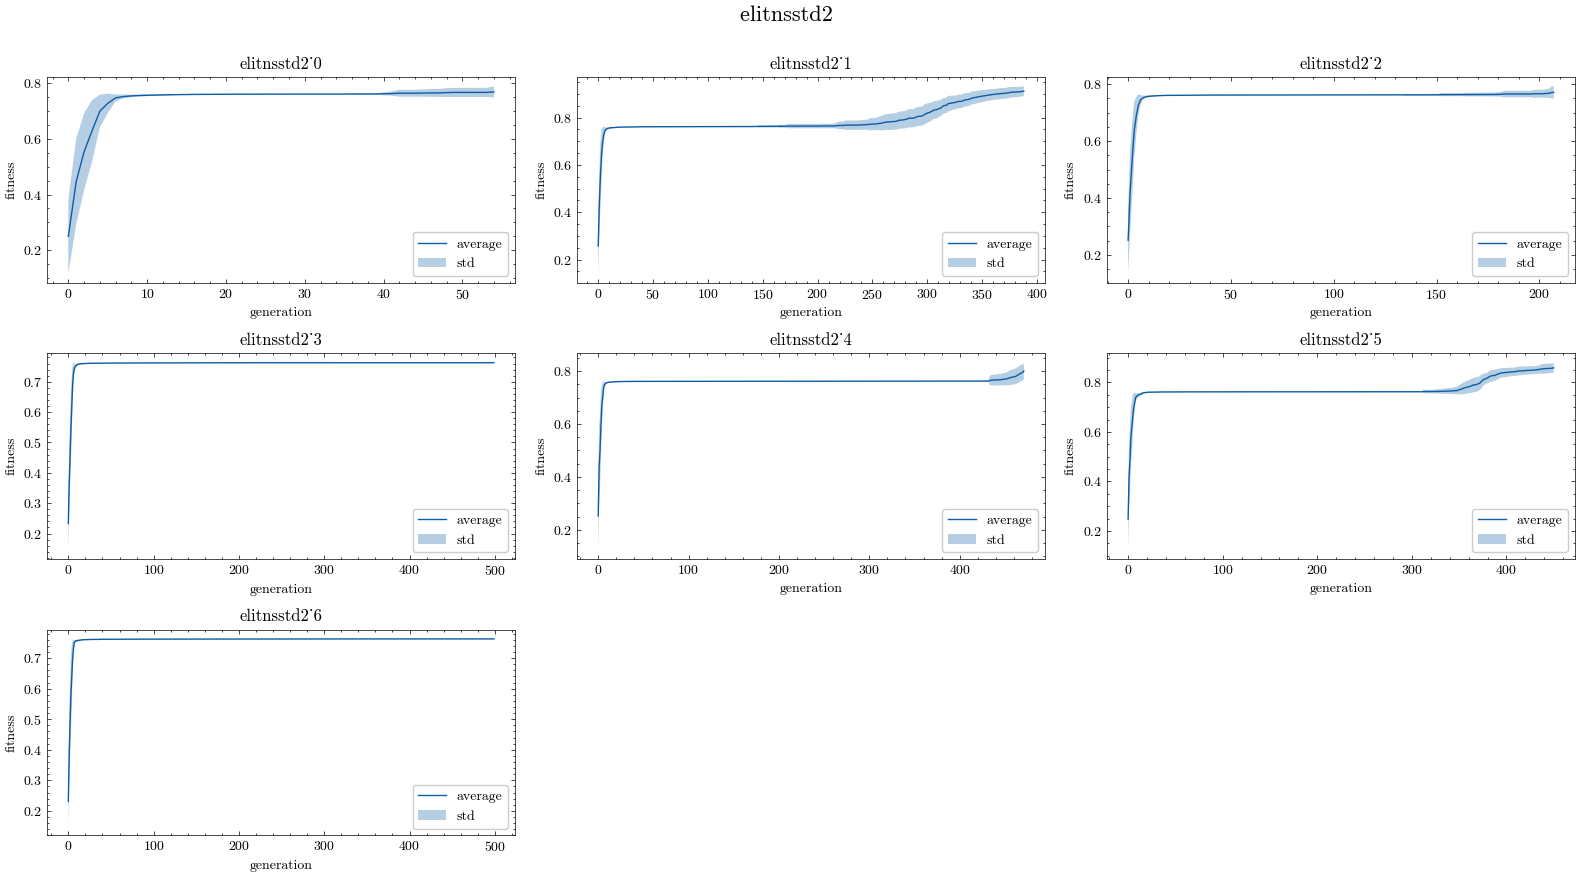

In [16]:
num_trials = 7

for exp_name in exp_name_uniques:
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_fitness.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f"{exp_name} ", fontsize=16)
    axs = [fig.add_subplot(num_row, 3, i+1) for i in range(num_trials)]

    # y軸は0から10000に固定
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_novelty_archive = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness_archive.csv"))

        hist_fitness_archive_avg, hist_fitness_archive_std = get_mean_std(df_novelty_archive)

        axs[i].plot(hist_fitness_archive_avg, label="average")
        axs[i].fill_between(range(len(hist_fitness_archive_avg)), hist_fitness_archive_avg-hist_fitness_archive_std, hist_fitness_archive_avg+hist_fitness_archive_std, alpha=0.3, label="std")
        axs[i].set_title(f"{exp_trial}")
        axs[i].set_xlabel("generation")
        axs[i].set_ylabel("fitness")
        axs[i].legend()
        axs[i].grid()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_fitness_archive.png"))
    plt.show()

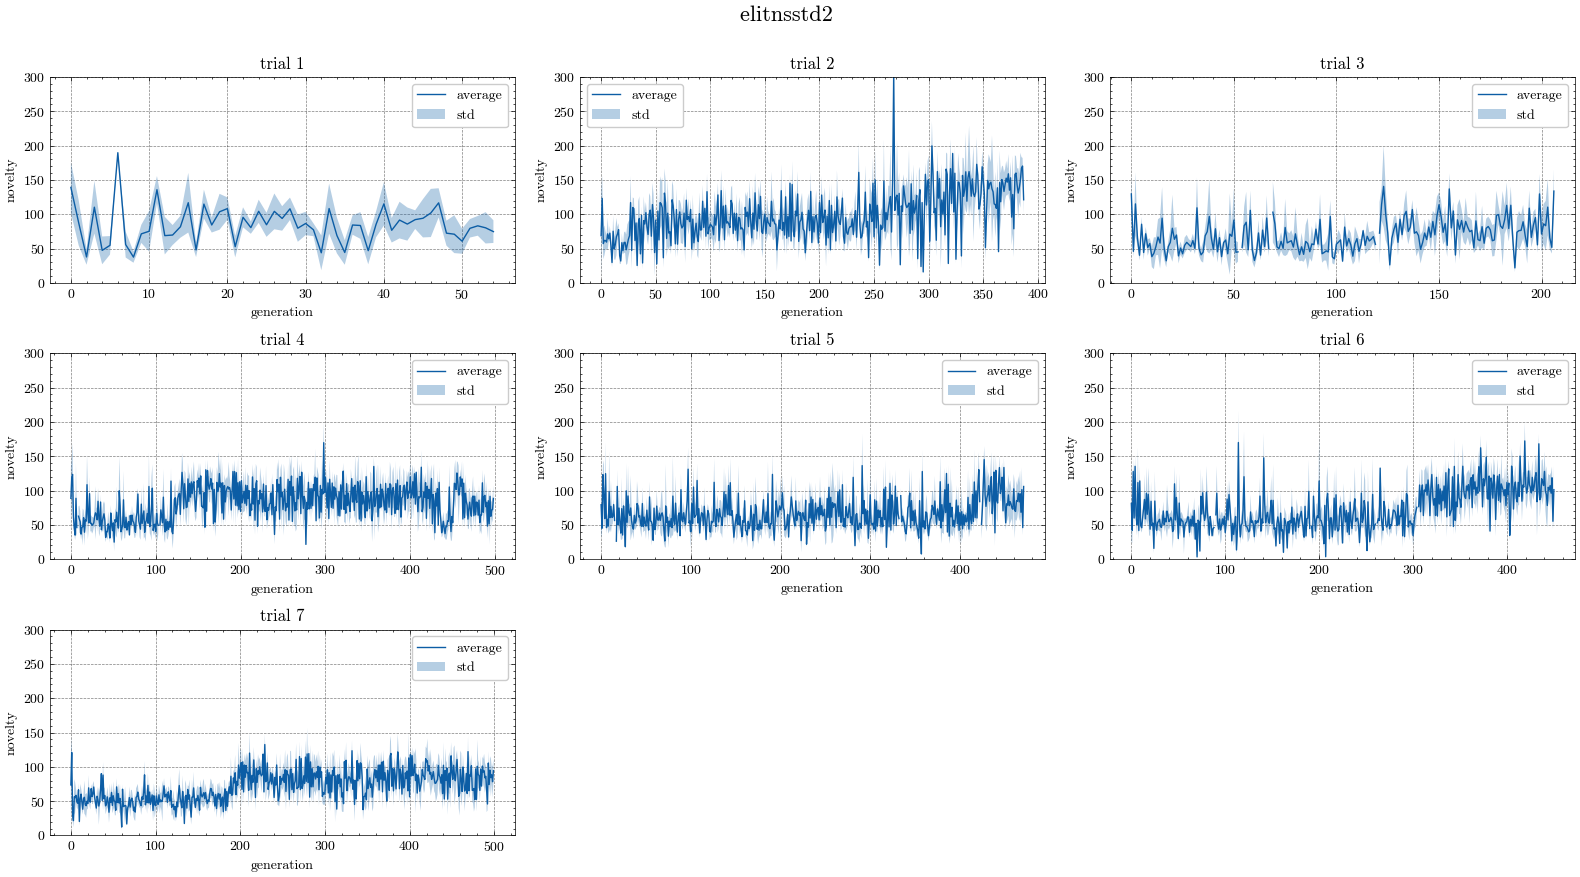

In [12]:
num_trials = 7

for exp_name in exp_name_uniques:
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_fitness.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f"{exp_name} ", fontsize=16)
    axs = [fig.add_subplot(num_row, 3, i+1) for i in range(num_trials)]
    # y軸は0から10000に固定
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_novelty_archive = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_novelty_archive.csv"))

        hist_novelty_archive_avg, hist_novelty_archive_std = get_novelty_mean_std(df_novelty_archive)

        axs[i].plot(hist_novelty_archive_avg, label="average")
        axs[i].fill_between(range(len(hist_novelty_archive_avg)), hist_novelty_archive_avg-hist_novelty_archive_std, hist_novelty_archive_avg+hist_novelty_archive_std, alpha=0.3, label="std")
        
        axs[i].set_ylim([0, 300])
        axs[i].set_title(f"trial {i+1}")
        axs[i].set_xlabel("generation")
        axs[i].set_ylabel("novelty")
        axs[i].legend()
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_novelty.png"))
    plt.show()

Tria 1: Mean Novelty 74.75665429146662, Std Novelty 16.50823968841108
Tria 2: Mean Novelty 121.13145582340228, Std Novelty 21.461639759229264
Tria 3: Mean Novelty 133.80290984523845, Std Novelty 31.69826210523125
Tria 4: Mean Novelty 88.5021667105903, Std Novelty 18.769746331920683
Tria 5: Mean Novelty 105.90854916449845, Std Novelty 10.443234257928276
Tria 6: Mean Novelty 101.3367191830601, Std Novelty 34.88246480921672
Tria 7: Mean Novelty 94.38828635118962, Std Novelty 16.21417006870892


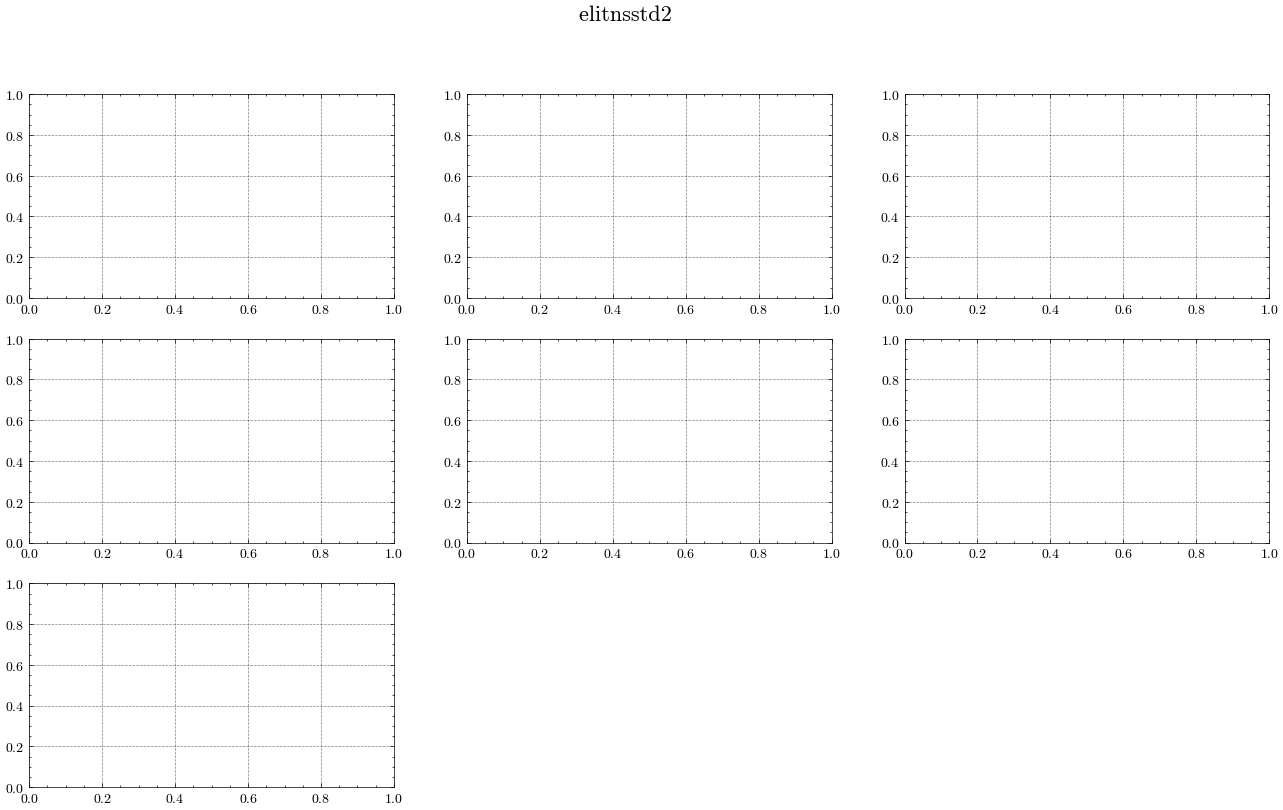

In [13]:
num_trials = 7

for exp_name in exp_name_uniques:
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_fitness.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f"{exp_name} ", fontsize=16)
    axs = [fig.add_subplot(num_row, 3, i+1) for i in range(num_trials)]
    # y軸は0から10000に固定
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_novelty_archive = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_novelty_archive.csv"))

        hist_novelty_archive_avg, hist_novelty_archive_std = get_novelty_mean_std(df_novelty_archive)

        print(f"Tria {i+1}: Mean Novelty {hist_novelty_archive_avg[-1]}, Std Novelty {hist_novelty_archive_std[-1]}")

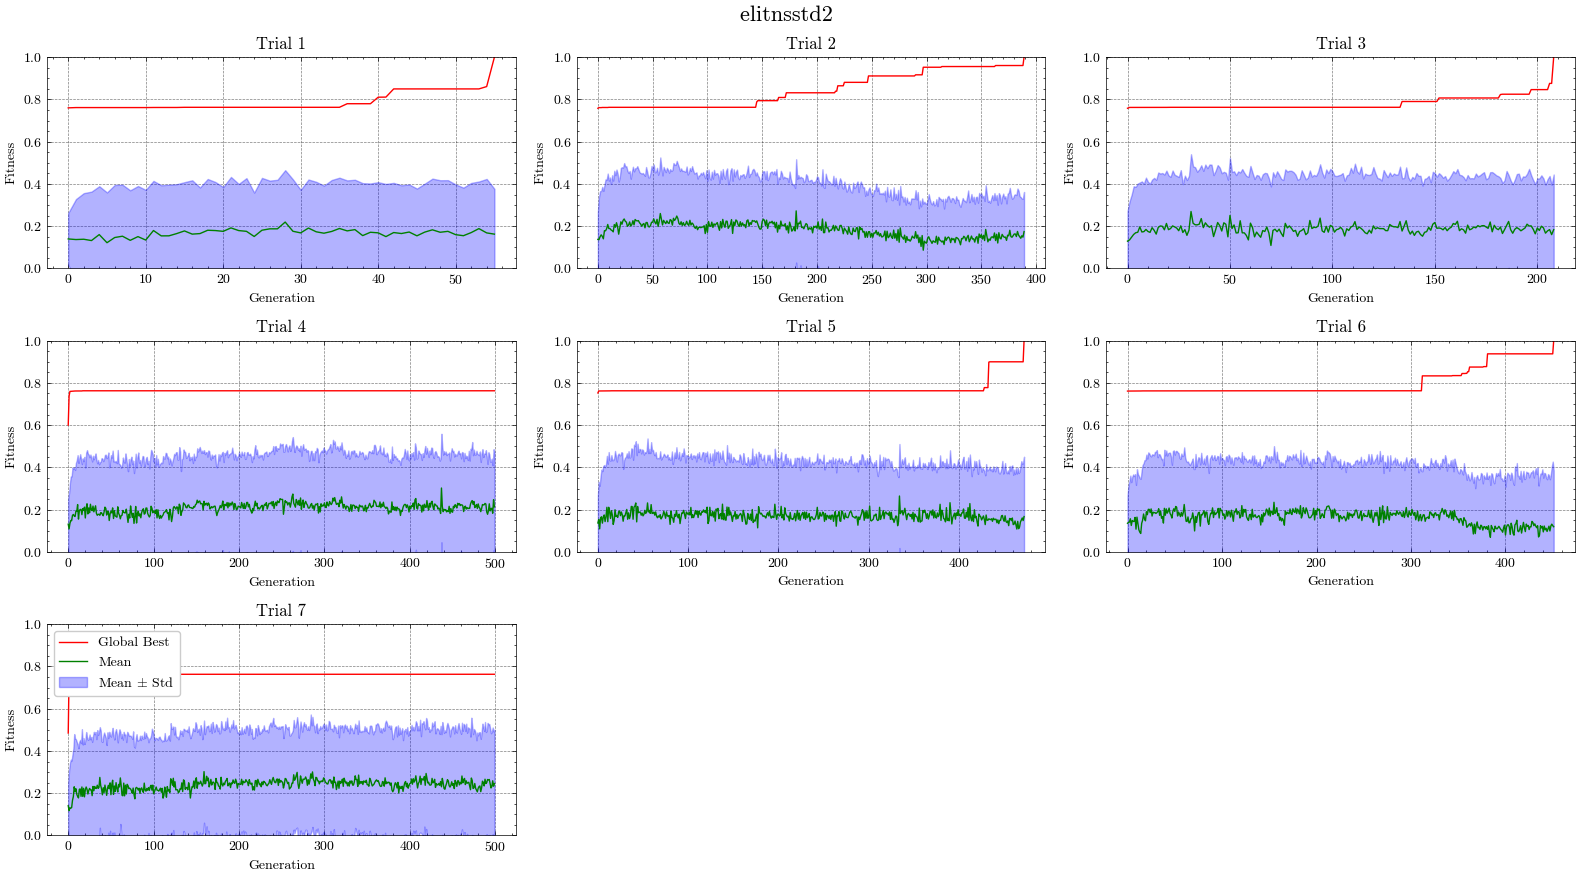

In [7]:
num_trials = 7

for exp_name in exp_name_uniques:
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_fitness.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f"{exp_name} ", fontsize=16)
    axs = [fig.add_subplot(num_row, 3, i+1) for i in range(num_trials)]
    # y軸は0から10000に固定
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        try:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness.csv"))
        except:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))

        try:
            global_bests = get_global_bests(df_history_fitness["fitness"].values)
        except:
            global_bests = get_global_bests(df_history_fitness["score"].values)
        hist_avg_fit, hist_std_fit = get_mean_std(df_history_pop)

        axs[i].plot(global_bests, label="Global Best", color="red")
        axs[i].plot(hist_avg_fit, label="Mean", color="green")
        axs[i].fill_between(range(len(global_bests)), hist_avg_fit-hist_std_fit, hist_avg_fit+hist_std_fit, alpha=0.3, label="Mean $\pm$ Std", color="blue")
        axs[i].set_ylim(0, 1.0)
        axs[i].set_title(f"Trial {i+1}")
        axs[i].set_xlabel("Generation")
        axs[i].set_ylabel("Fitness")
        if i == num_trials-1:
            axs[i].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_fitness.png"))
    plt.show()
    plt.close()

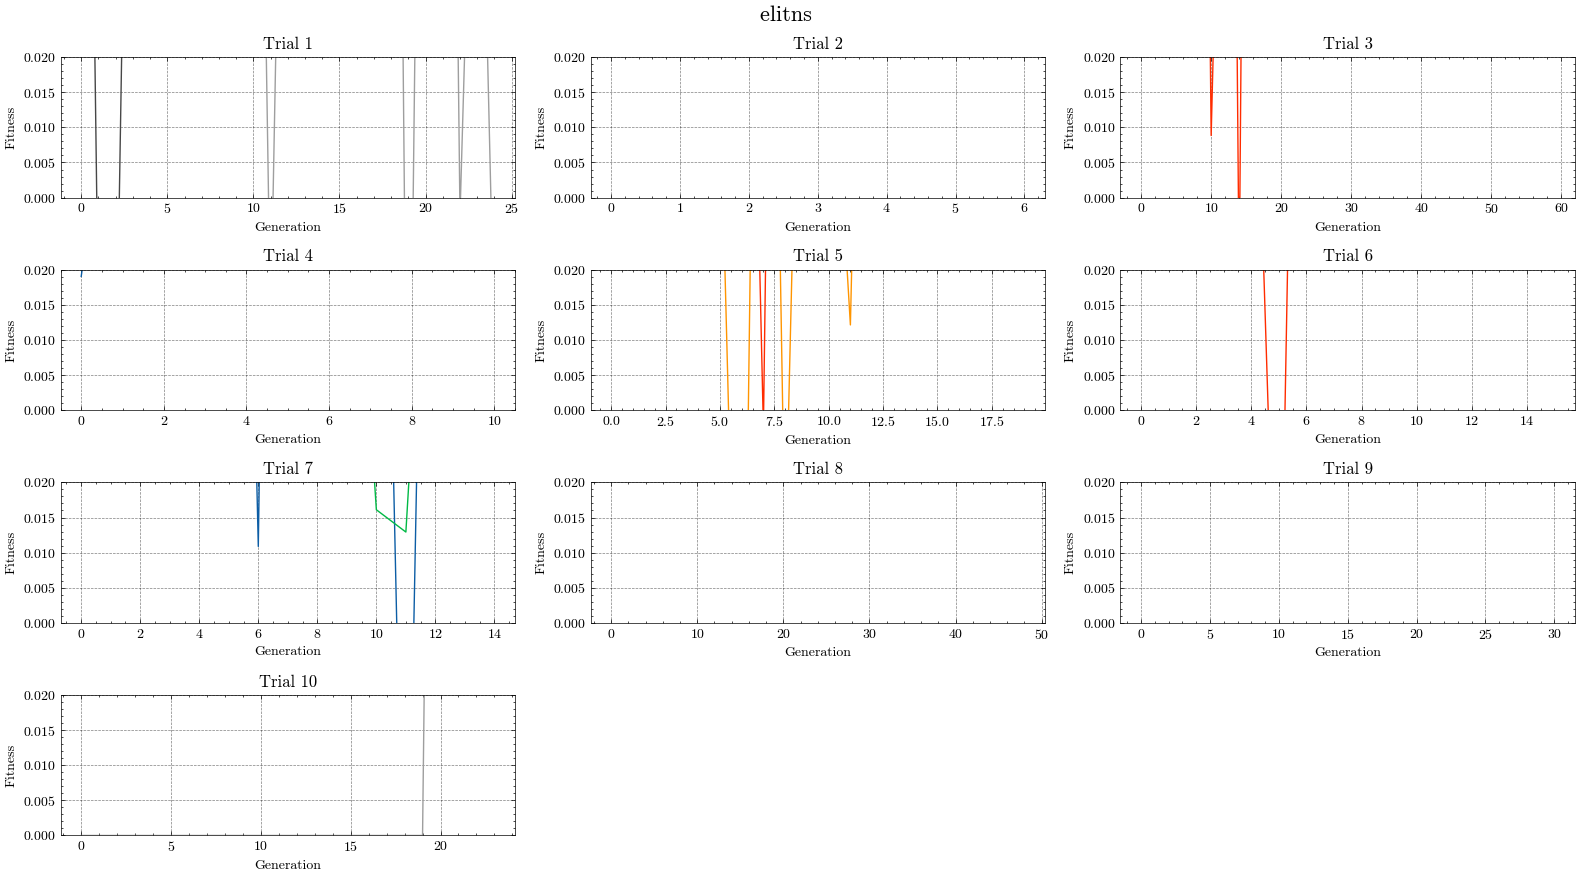

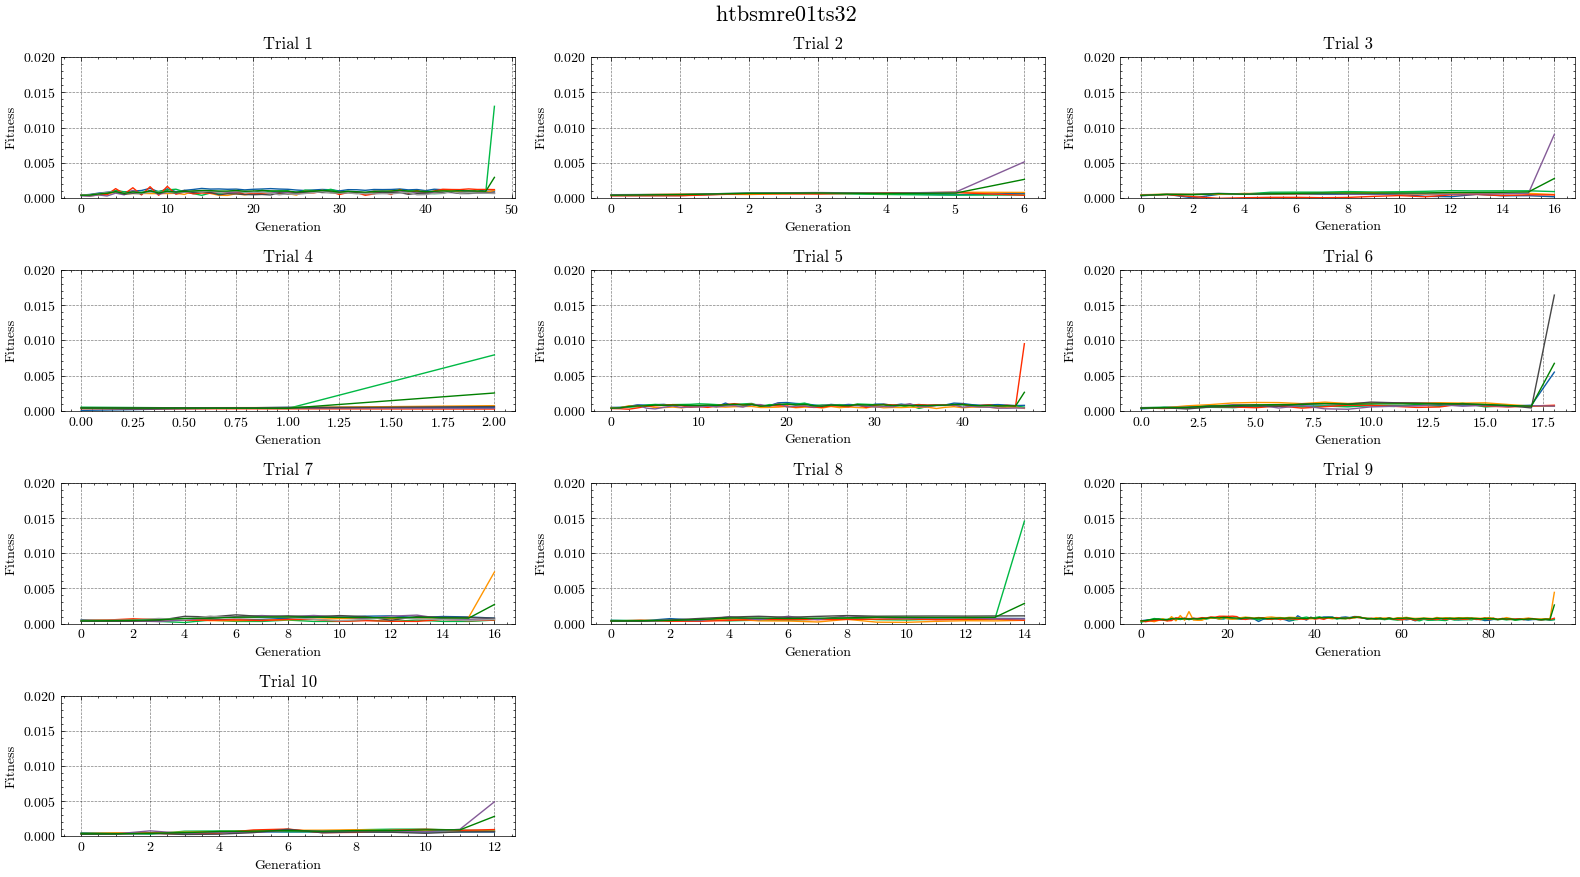

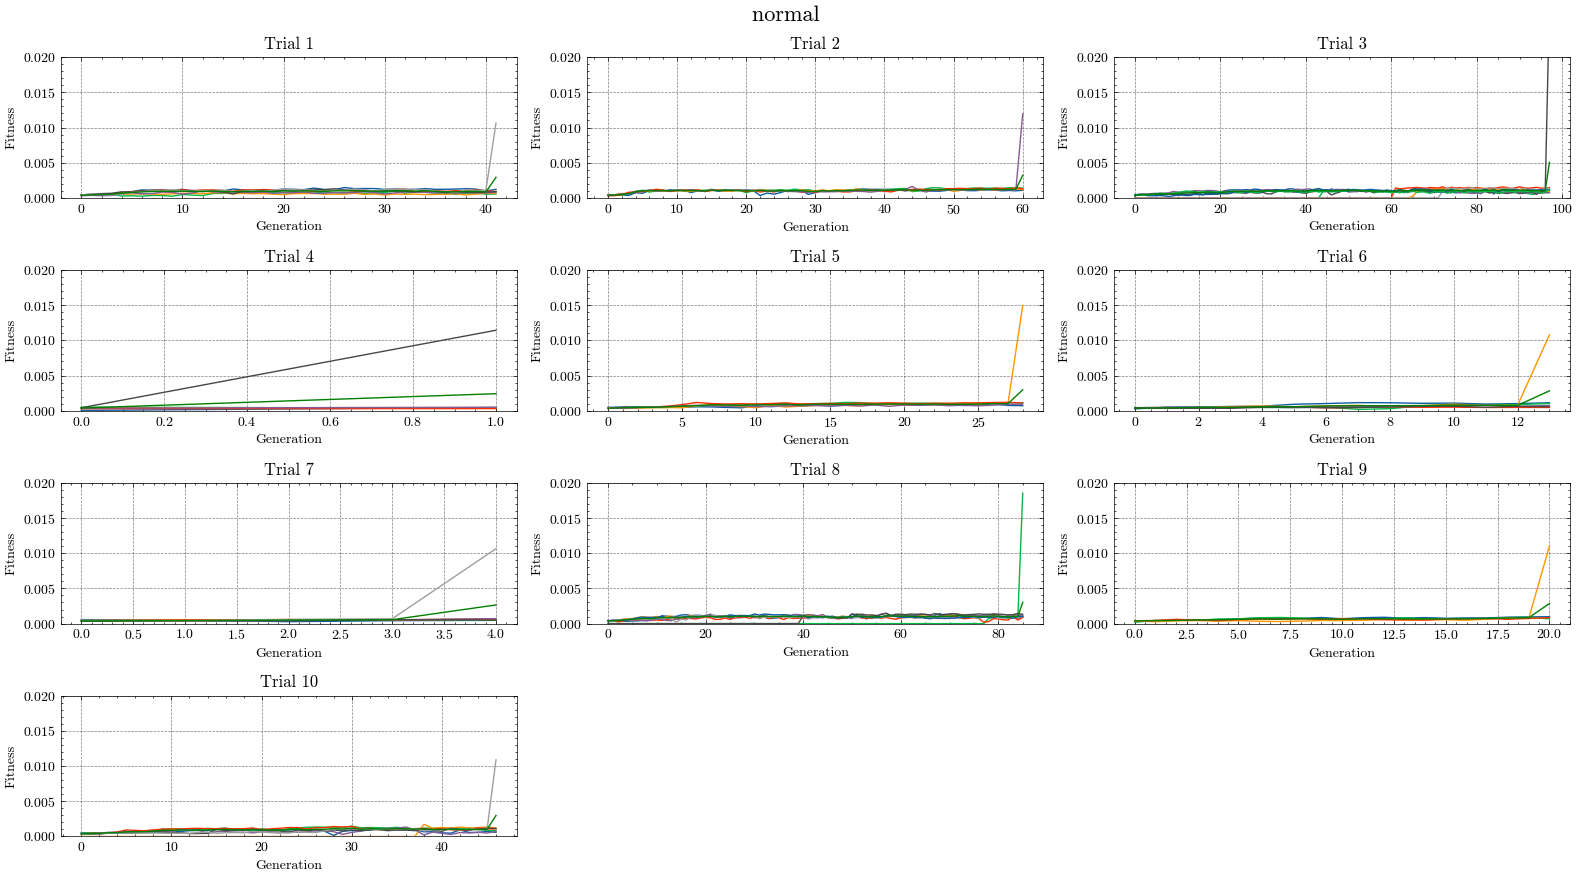

In [6]:
num_trials = 10

for exp_name in exp_name_uniques:
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_species_fit.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()
    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f"{exp_name} ", fontsize=16)
    axs = [fig.add_subplot(num_row, 3, i+1) for i in range(num_trials)]
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        species_data = get_species_statistics(df_history_pop)
        species_order = get_species_order(species_data)
        for key in species_order:
            species = species_data[key]
            mean_fit = species["fitness_hist_average"]
            
            axs[i].plot(mean_fit, label=f"Species {key}")

        hist_avg_fit, hist_std_fit = get_mean_std(df_history_pop)
        axs[i].plot(hist_avg_fit, label="Mean", color="green")
        axs[i].set_ylim(0, 0.02)
        axs[i].set_title(f"Trial {i+1}")
        axs[i].set_xlabel("Generation")
        axs[i].set_ylabel("Fitness")
        # if i == num_trials-1:
        #     axs[i].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_species_fit.png"))
    plt.show()
    plt.close()

In [ ]:
num_trials = 10

for exp_name in exp_name_uniques:
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_global_best.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))

    for i, exp_trial in enumerate(exp_traials[4:num_trials]):
        try:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_novelty_archive.csv"))
        except:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))

        try:
            global_bests = get_global_bests(df_history_fitness["fitness"].values)
        except:
            global_bests = get_global_bests(df_history_fitness["score"].values)
        plt.plot(global_bests, label=f"Trial {i+1}")

    plt.title(f"{exp_name} Global Best")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.ylim(0, 1.1)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_global_best.png"))
    plt.show()
    plt.close()

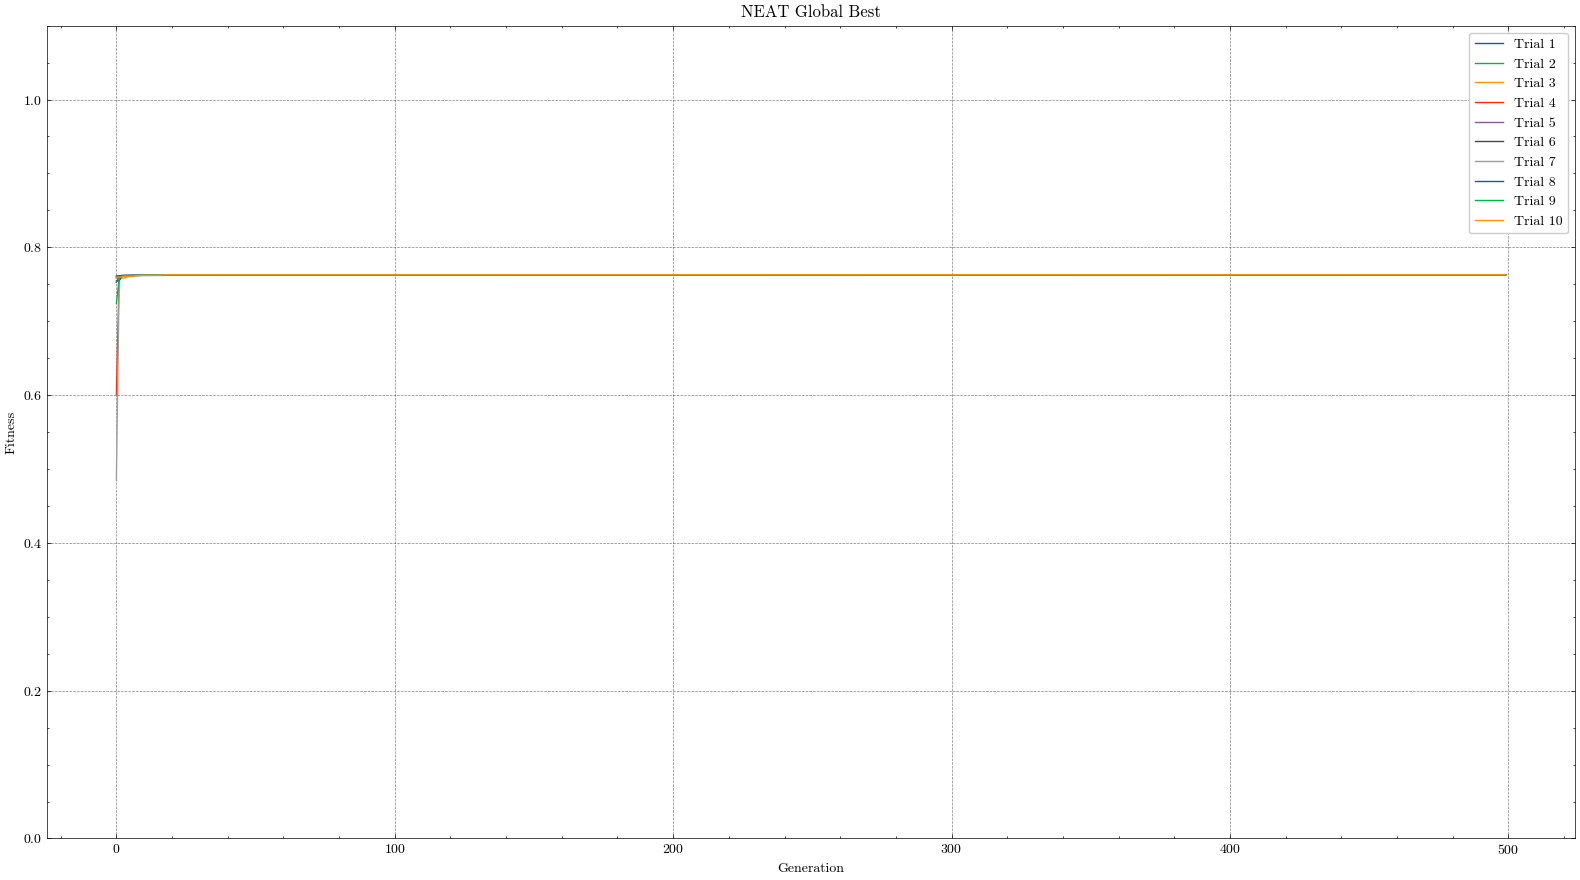

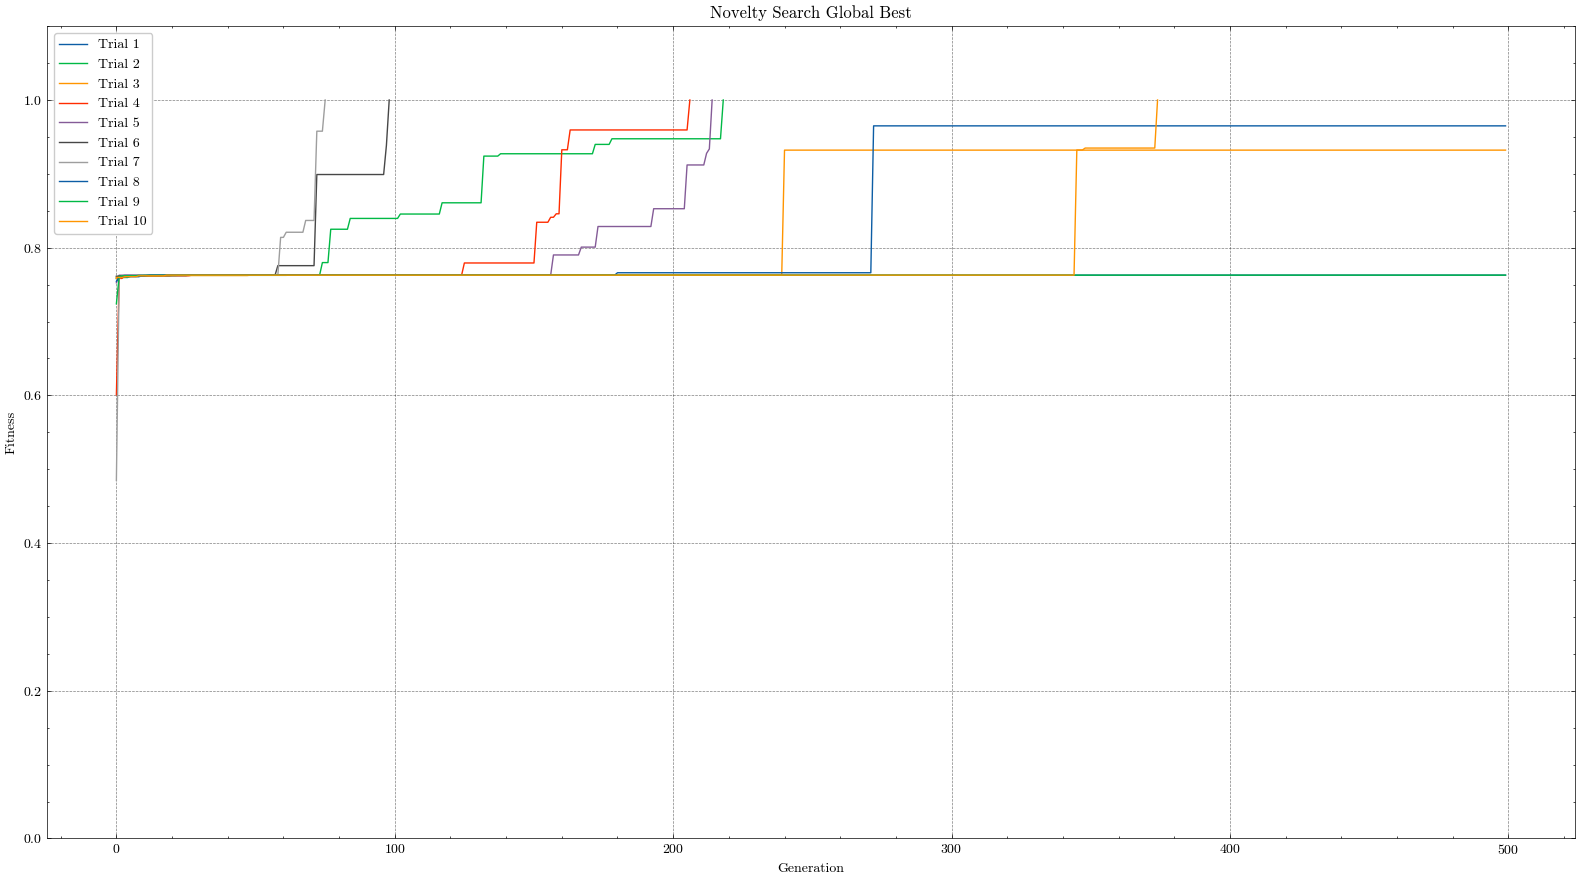

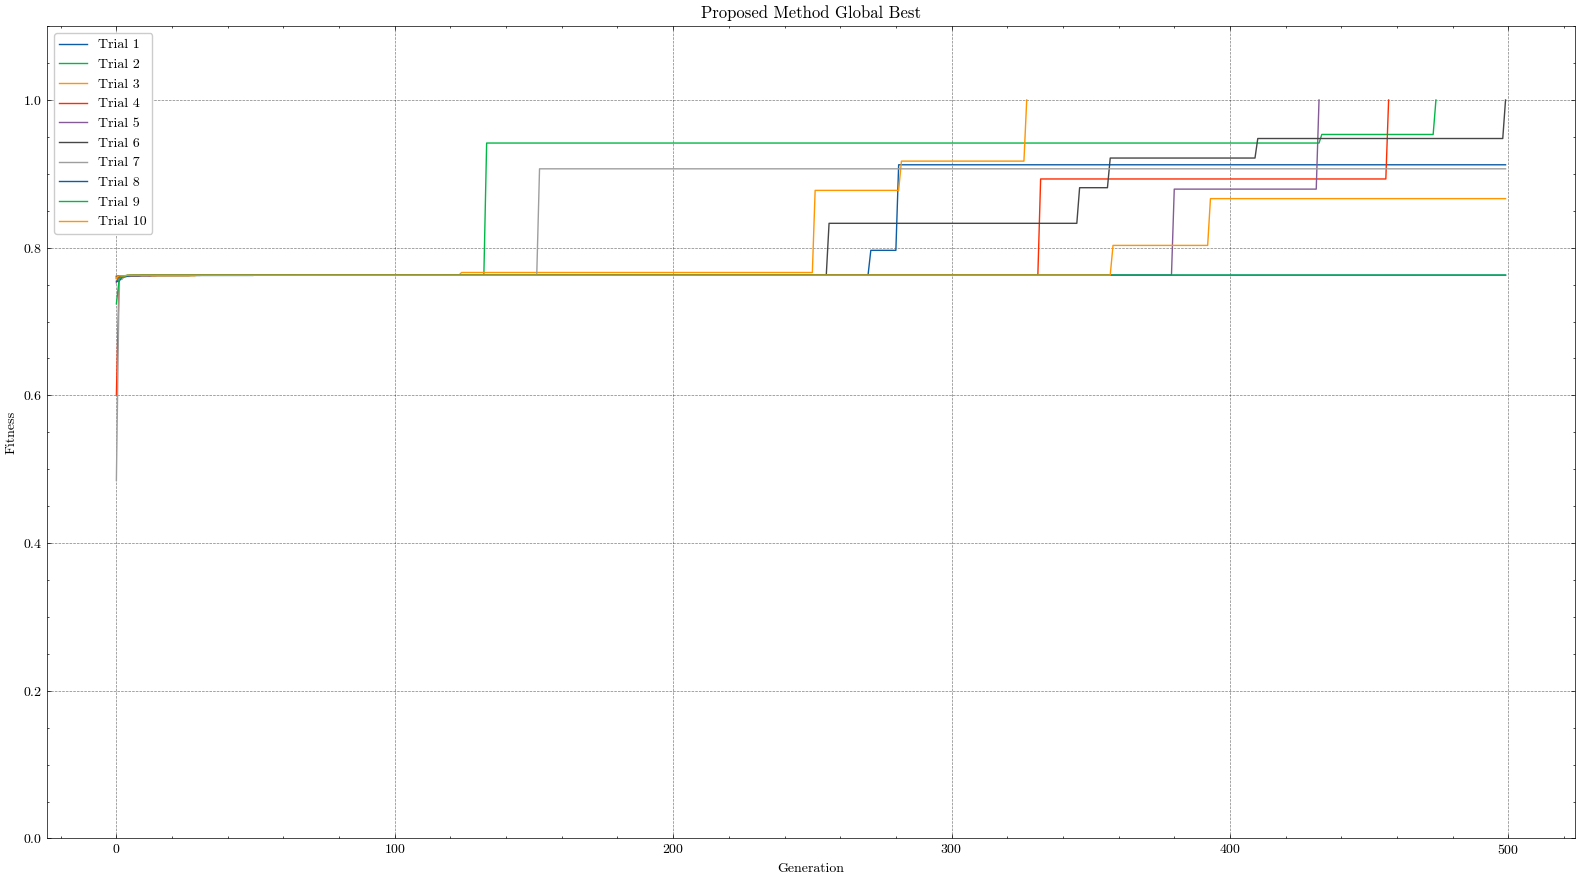

In [13]:
num_trials = 10
exp_name_uniques = ["normal", "ns", "elitns"]
names = ["NEAT", "Novelty Search", "Proposed Method"]

for idx, exp_name in enumerate(exp_name_uniques):
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_global_best.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))

    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        try:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness.csv"))
        except:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))

        try:
            global_bests = get_global_bests(df_history_fitness["fitness"].values)
        except:
            global_bests = get_global_bests(df_history_fitness["score"].values)
        plt.plot(global_bests, label=f"Trial {i+1}")

    plt.title(f"{names[idx]} Global Best")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.ylim(0, 1.1)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_global_best.png"))
    plt.show()
    plt.close()

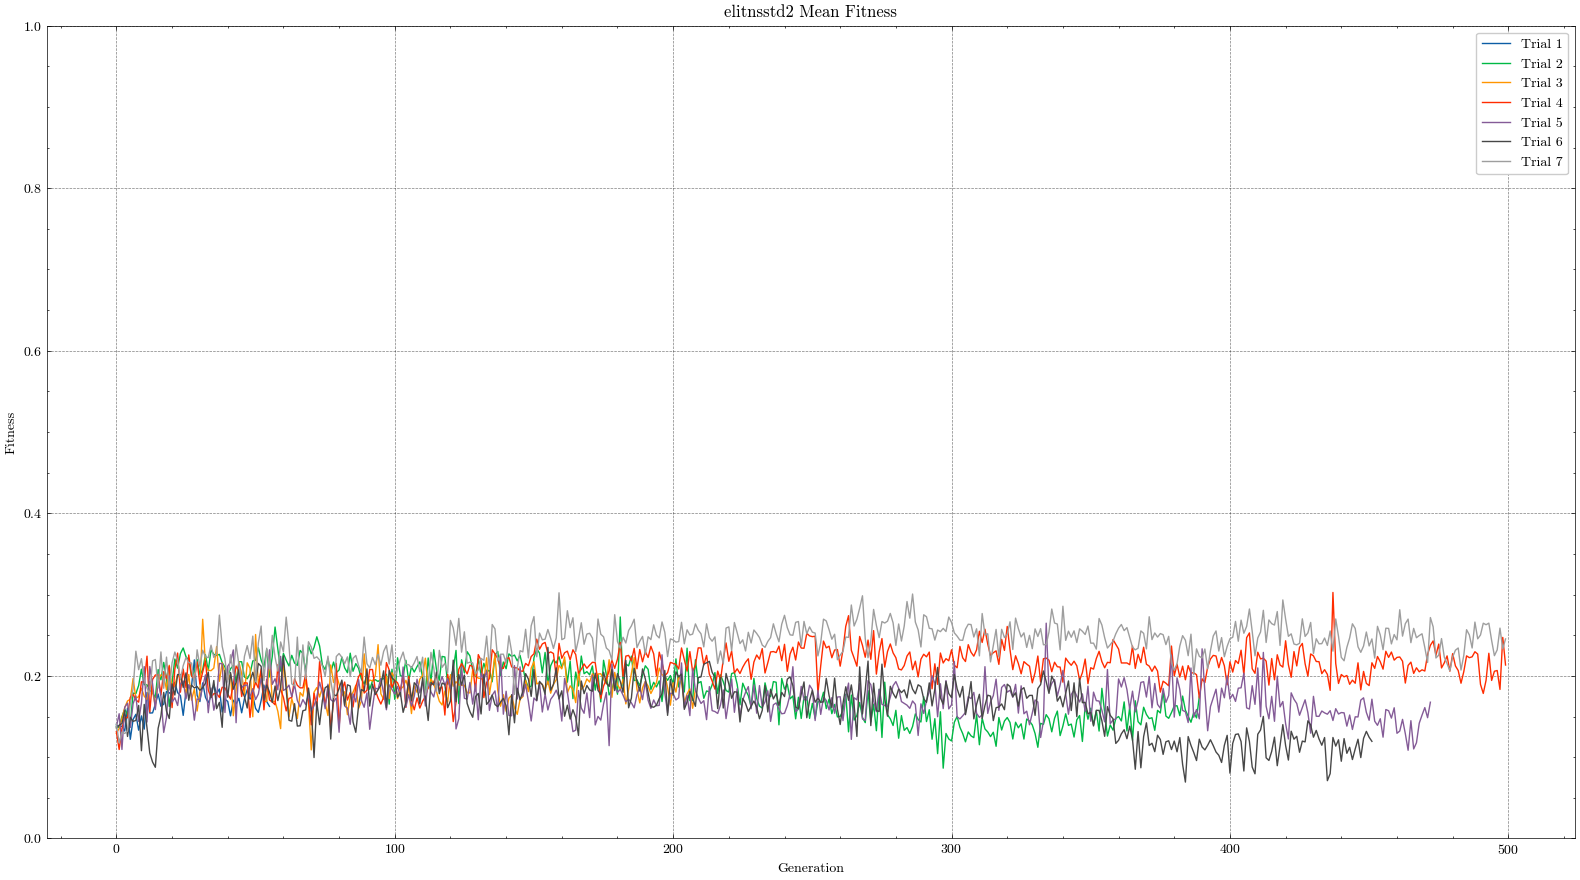

In [9]:
num_trials = 7

for exp_name in exp_name_uniques:
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_mean_fit.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))

    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        mean_fit, _ = get_mean_std(df_history_pop)

        plt.plot(mean_fit, label=f"Trial {i+1}")

    plt.title(f"{exp_name} Mean Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.ylim(0, 1.0)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_mean_fit.png"))
    plt.show()
    plt.close()

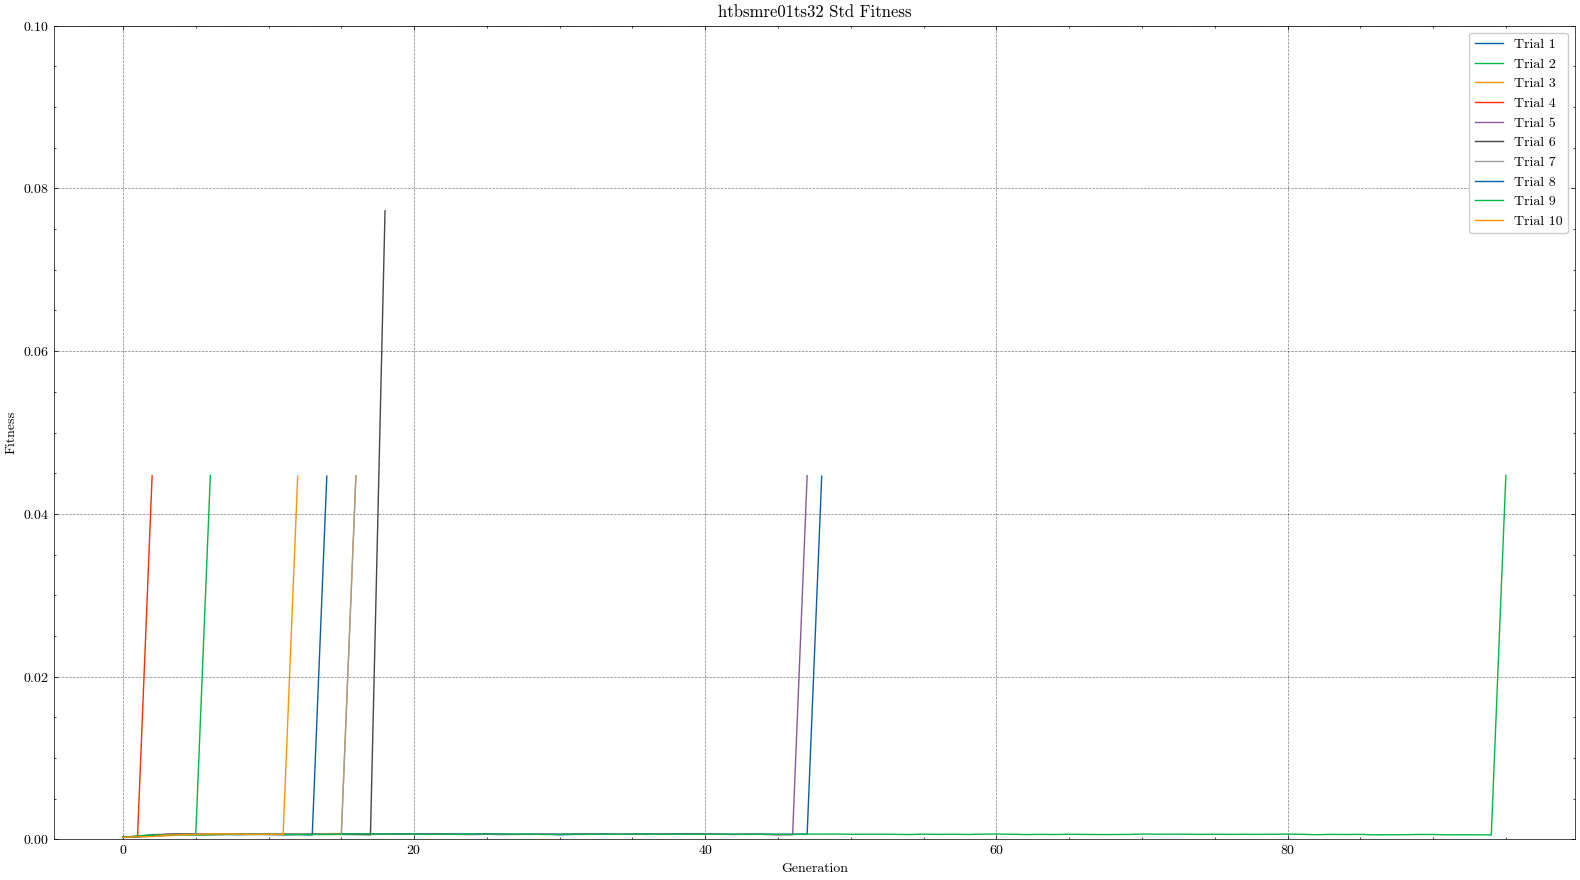

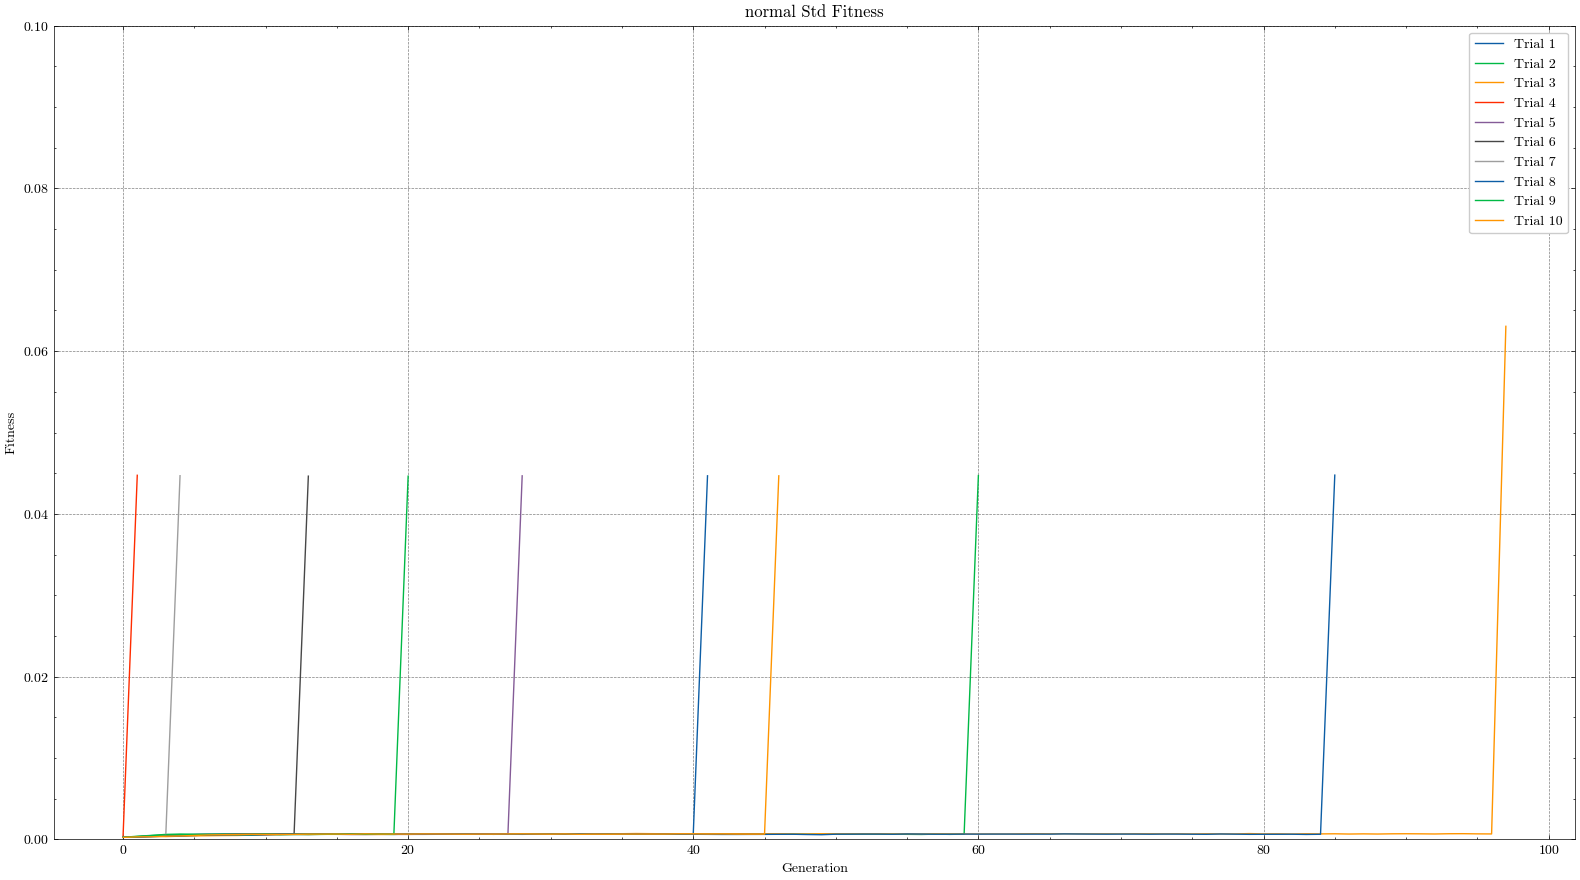

In [16]:
num_trials = 10

for exp_name in exp_name_uniques:
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_std_fit.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))

    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        _, std_fit = get_mean_std(df_history_pop)

        plt.plot(std_fit, label=f"Trial {i+1}")

    plt.title(f"{exp_name} Std Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.ylim(0, 0.1)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_std_fit.png"))
    plt.show()
    plt.close()

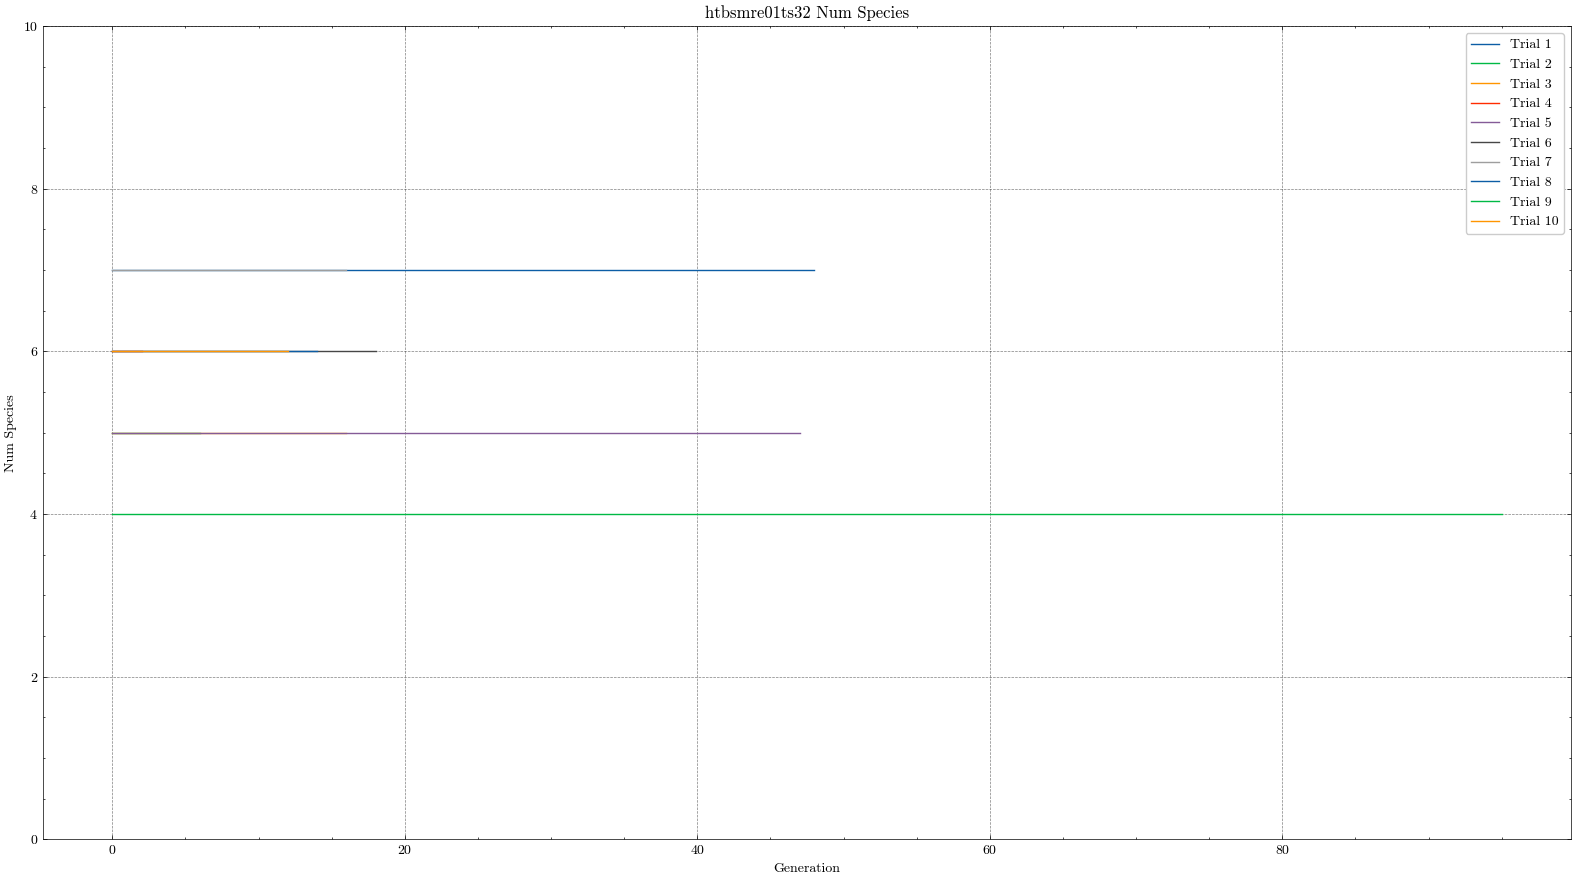

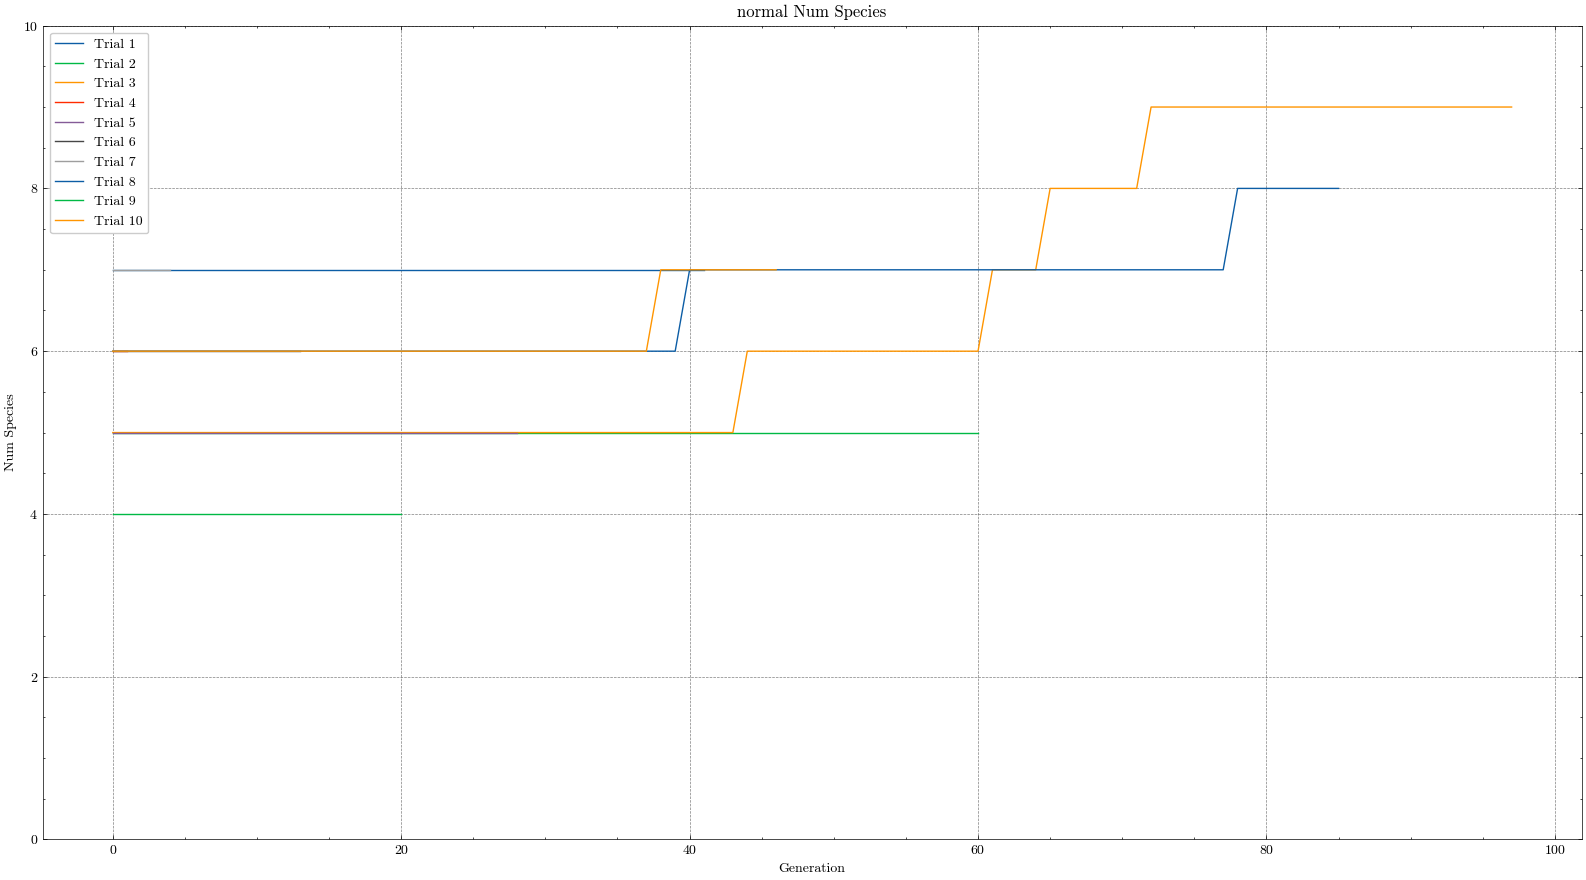

In [17]:
num_trials = 10

for exp_name in exp_name_uniques:
    if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_num_species.png")):
        continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))

    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        num_species_hist = get_num_species_hist(df_history_pop)

        plt.plot(num_species_hist, label=f"Trial {i+1}")

    plt.title(f"{exp_name} Num Species")
    plt.xlabel("Generation")
    plt.ylabel("Num Species")
    plt.legend()

    plt.tight_layout()
    plt.ylim(0, 10)
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_num_species.png"))
    plt.show()
    plt.close()

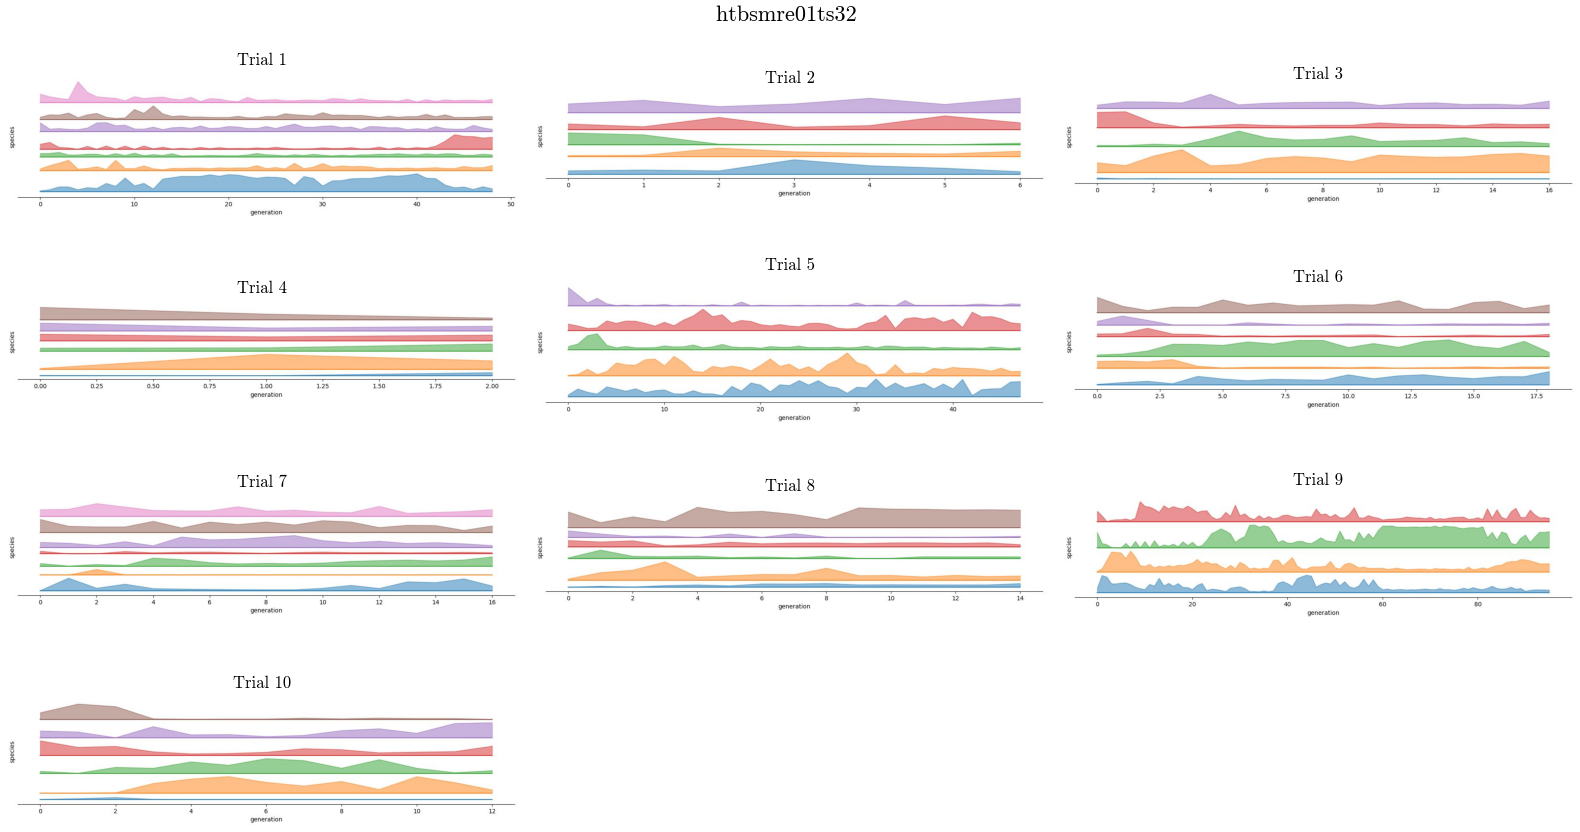

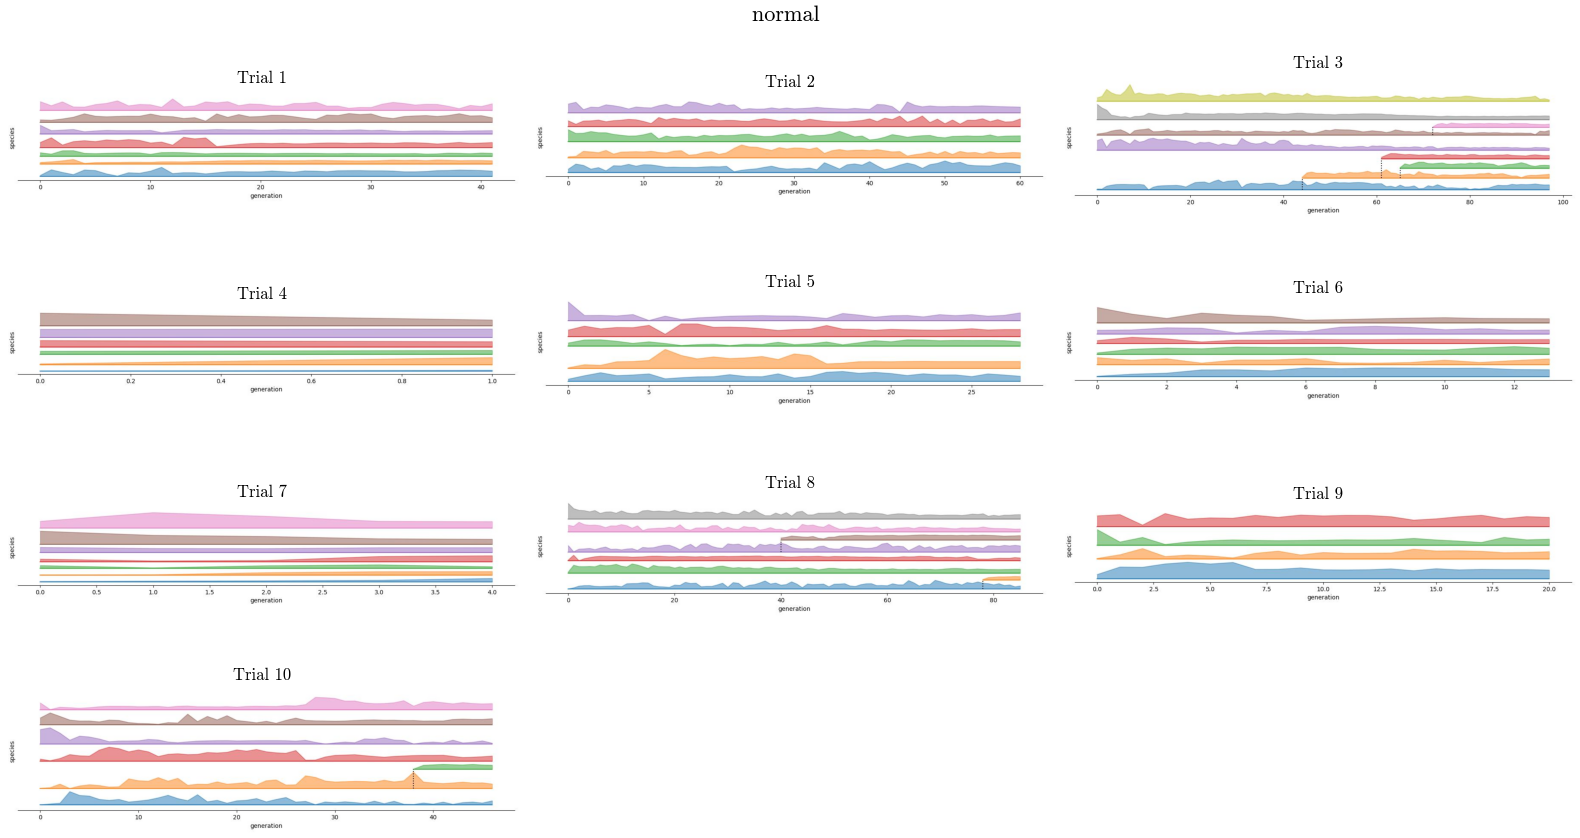

In [18]:
num_trials = 10

for exp_name in exp_name_uniques:
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_species_img.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f"{exp_name} ", fontsize=16)
    axs = [fig.add_subplot(num_row, 3, i+1) for i in range(num_trials)]
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        species_img = plt.imread(os.path.join(EXP_DIR, exp_trial, "species.jpg"))

        axs[i].imshow(species_img)
        axs[i].axis("off")
        axs[i].set_title(f"Trial {i+1}")

    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_species_img.png"))
    plt.show()
    plt.close()

In [11]:
num_trials = 10
exp_name_uniques = ["elitns", "ns", "normal"]
for exp_name in exp_name_uniques:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    best_fits = []
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        try:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness.csv"))
            num_trials = 10
        except:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))
            num_trials = 10
        try:
            best_fits.append(df_history_fitness["fitness"].max())
        except:
            best_fits.append(df_history_fitness["score"].max())

    mean = np.mean(best_fits)
    std = np.std(best_fits)
    print(f"{exp_name} Best Fitness: {np.mean(best_fits)} ± {np.std(best_fits)}")

elitns Best Fitness: 0.9211196733101972 ± 0.09191430752706299
ns Best Fitness: 0.9422774147842556 ± 0.0921966567373852
normal Best Fitness: 0.7628464125267478 ± 1.4782677527715968e-05


In [45]:
num_trials = 10

for exp_name in exp_name_uniques:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    num_species = []
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        num_specie = len(df_history_pop["species"].unique())
        num_species.append(num_specie)

    mean = np.mean(best_fits)
    print(f"{exp_name} Num Species: {np.mean(num_species)} ± {np.std(num_species)}")

hybsmrets32 Num Species: 8.1 ± 1.57797338380595
normal Num Species: 19.4 ± 2.244994432064365


In [14]:
for exp_name in exp_name_uniques:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    found_solution_gens = []
    if exp_name == "elitns":
        num_trials = 4
    else:
        num_trials = 10
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        try:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness.csv"))
        except:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))
        found_solution_gen = len(df_history_fitness)
        if found_solution_gen != 500:
            found_solution_gens.append(found_solution_gen)

    if len(found_solution_gens) > 0:
        mean = np.mean(found_solution_gens)
        print(f"{exp_name} Found Solution Generation: {np.mean(found_solution_gens)} ± {np.std(found_solution_gens)}")

elitns Found Solution Generation: 420.3333333333333 ± 65.65735974655766


In [5]:
exp_name_uniques

['elitnsact',
 'elitnsnov150',
 'elitnsnov300',
 'elitns',
 'hybsmrets32',
 'normal',
 'ns']

In [5]:
num_trials = 10
for exp_name in ["normal", "hybsmre01ts32", "hybsmre01elitts32"]:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    best_fits = []
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness.csv"))
        best_fits.append(df_history_fitness["fitness"].max())

    mean = np.mean(best_fits)
    std = np.std(best_fits)
    print(f"{exp_name} Best Fitness: {np.mean(best_fits)} ± {np.std(best_fits)}")

normal Best Fitness: 0.7628464125267478 ± 1.4782677527715968e-05
hybsmre01ts32 Best Fitness: nan ± nan
hybsmre01elitts32 Best Fitness: nan ± nan


C:\Users\daiki\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\daiki\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\daiki\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\daiki\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\daiki\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
for exp_name in ["normal", "hybsmre01ts32", "hybsmre01elitts32"]:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    num_species = []
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        num_specie = len(df_history_pop["species"].unique())
        num_species.append(num_specie)

    mean = np.mean(best_fits)
    print(f"{exp_name} Num Species: {np.mean(num_species)} ± {np.std(num_species)}")

normal Num Species: 10.5 ± 2.1095023109728985
hybsmre01ts32 Num Species: 6.4 ± 1.2806248474865698
hybsmre01elitts32 Num Species: 6.6 ± 1.4966629547095764


In [ ]:
exp_name_uniques = ["elitns", "ns"]

for exp_name in exp_name_uniques:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    num_species = []
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        num_specie = len(df_history_pop["species"].unique())
        num_species.append(num_specie)

    mean = np.mean(best_fits)
    print(f"{exp_name} Num Species: {np.mean(num_species)} ± {np.std(num_species)}")


In [ ]:
algo_name = "hybsmre01ts32_1"

file_path = os.path.join(EXP_DIR, algo_name, "genome")

# ファイル名のリストを取得
file_names = os.listdir(file_path)
file_names.sort(key=lambda x: int(x.split(".")[0]), reverse=True)
print(file_names[0])

69662.pickle


In [10]:
# ファイルを読み込む
col_names = ["id(key)", "fitness", "num_input", "num_output", "num_hidden", "num_connection", "num_params"]
algo_names = ["normal", "elitns", "ns"]
df = pd.DataFrame()

for an in algo_names:
    df = pd.DataFrame()
    for i in range(10):
        # print(f"Trial {i}")
        algo_name = an + "_" + str(i)

        file_path = os.path.join(EXP_DIR, algo_name, "genome")

        # ファイル名のリストを取得
        file_names = os.listdir(file_path)
        file_names.sort(key=lambda x: int(x.split(".")[0]), reverse=True)
        print(file_names[0])
        file_path = os.path.join(file_path, file_names[0])
        with open(file_path, "rb") as f:
            genome = pickle.load(f)

        num_out = 2
        num_input = 10
        network_info = {
            "id(key)": genome.key,
            "fitness": genome.fitness,
            "num_input": num_input,
            "num_output": num_out,
            "num_hidden": None,
            "num_connection": None,
            "num_params": None
        }

        network_info["num_hidden"] = len(genome.nodes) - num_out
        network_info["num_connection"] = len(genome.connections)
        network_info["num_params"] = network_info["num_connection"]

        df = pd.concat([df, pd.DataFrame(network_info, index=[i])])

        # print(network_info)
        # print()
    mean_num_hidden = df["num_hidden"].mean()
    std_num_hidden = df["num_hidden"].std()
    mean_num_connection = df["num_connection"].mean()
    std_num_connection = df["num_connection"].std()
    mean_fit = df["fitness"].mean()
    std_fit = df["fitness"].std()

    print(f"Algo: {an}")
    print(f"Mean Fitness: {mean_fit} ± {std_fit}")
    print(f"Mean Num Hidden: {mean_num_hidden} ± {std_num_hidden}")
    print(f"Mean Num Connection: {mean_num_connection} ± {std_num_connection}")
    print()
    

235141.pickle
242623.pickle
162205.pickle
172068.pickle
80605.pickle
214163.pickle
217056.pickle
15098.pickle
90393.pickle
198352.pickle
Algo: normal
Mean Fitness: 0.7628464125267478 ± 1.5582310301123112e-05
Mean Num Hidden: 1.5 ± 1.5811388300841898
Mean Num Connection: 17.4 ± 4.718756898449704

249895.pickle
237500.pickle
163589.pickle
228607.pickle
216420.pickle
249529.pickle
249778.pickle
249884.pickle
249536.pickle
249856.pickle
Algo: elitns
Mean Fitness: 0.8811212770430739 ± 0.12530968458674807
Mean Num Hidden: 1.3 ± 0.9486832980505139
Mean Num Connection: 16.9 ± 3.6953424138441564

242546.pickle
107381.pickle
243056.pickle
100101.pickle
105342.pickle
47875.pickle
36940.pickle
155929.pickle
244012.pickle
182380.pickle
Algo: ns
Mean Fitness: 27.76265575238391 ± 13.574499246070834
Mean Num Hidden: 1.6 ± 2.3664319132398464
Mean Num Connection: 20.0 ± 7.731609003162134



In [34]:
# ファイルを読み込む
col_names = ["id(key)", "fitness", "num_input", "num_output", "num_hidden", "num_connection", "num_params"]
df = pd.DataFrame()

for i in range(10):
    print(f"Trial {i}")
    algo_name = "normal_" + str(i)

    file_path = os.path.join(EXP_DIR, algo_name, "genome")

    # ファイル名のリストを取得
    file_names = os.listdir(file_path)
    file_names.sort(key=lambda x: int(x.split(".")[0]), reverse=True)
    # print(file_names[0])
    file_path = os.path.join(file_path, file_names[0])
    with open(file_path, "rb") as f:
        genome = pickle.load(f)

    num_out = 2
    num_input = 10
    network_info = {
        "id(key)": genome.key,
        "fitness": genome.fitness,
        "num_input": num_input,
        "num_output": num_out,
        "num_hidden": None,
        "num_connection": None,
        "num_params": None
    }

    network_info["num_hidden"] = len(genome.nodes) - num_out
    network_info["num_connection"] = len(genome.connections)
    network_info["num_params"] = network_info["num_connection"]

    df = pd.concat([df, pd.DataFrame(network_info, index=[i])])

    print(network_info)
    print()

Trial 0
{'id(key)': 20279, 'fitness': 1.0, 'num_input': 10, 'num_output': 2, 'num_hidden': 0, 'num_connection': 10, 'num_params': 10}

Trial 1
{'id(key)': 29862, 'fitness': 1.0, 'num_input': 10, 'num_output': 2, 'num_hidden': 0, 'num_connection': 13, 'num_params': 13}

Trial 2
{'id(key)': 47686, 'fitness': 1.0, 'num_input': 10, 'num_output': 2, 'num_hidden': 0, 'num_connection': 12, 'num_params': 12}

Trial 3
{'id(key)': 775, 'fitness': 1.0, 'num_input': 10, 'num_output': 2, 'num_hidden': 1, 'num_connection': 18, 'num_params': 18}

Trial 4
{'id(key)': 14211, 'fitness': 1.0, 'num_input': 10, 'num_output': 2, 'num_hidden': 2, 'num_connection': 21, 'num_params': 21}

Trial 5
{'id(key)': 6695, 'fitness': 1.0, 'num_input': 10, 'num_output': 2, 'num_hidden': 0, 'num_connection': 12, 'num_params': 12}

Trial 6
{'id(key)': 2388, 'fitness': 1.0, 'num_input': 10, 'num_output': 2, 'num_hidden': 1, 'num_connection': 18, 'num_params': 18}

Trial 7
{'id(key)': 41820, 'fitness': 1.0, 'num_input': 10,

In [35]:
df

,id(key),fitness,num_input,num_output,num_hidden,num_connection,num_params
0,20279,1.0,10,2,0,10,10
1,29862,1.0,10,2,0,13,13
2,47686,1.0,10,2,0,12,12
3,775,1.0,10,2,1,18,18
4,14211,1.0,10,2,2,21,21
5,6695,1.0,10,2,0,12,12
6,2388,1.0,10,2,1,18,18
7,41820,1.0,10,2,0,10,10
8,10299,1.0,10,2,0,12,12
9,22869,1.0,10,2,2,20,20


In [ ]:
mean_num_hidden = df["num_hidden"].mean()
std_num_hidden = df["num_hidden"].std()
mean_num_connection = df["num_connection"].mean()
std_num_connection = df["num_connection"].std()
mean_fit = df["fitness"].mean()
std_fit = df["fitness"].std()

print(f"Mean Fitness: {mean_fit} ± {std_fit}")
print(f"Mean Num Hidden: {mean_num_hidden} ± {std_num_hidden}")
print(f"Mean Num Connection: {mean_num_connection} ± {std_num_connection}")

Mean Fitness: 7955.400055876036 ± 2136.676723723234
Mean Num Hidden: 1.8 ± 2.3944379994757297
Mean Num Connection: 9.1 ± 5.762908216439952


In [ ]:
f = "elitnscompareelite"
